In [39]:
#!pipenv install pandas
import pandas as pd
#!pipenv install plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
#!pipenv install dash
#!pipenv install jupyter-dash
import dash
import dash_core_components as dcc
from dash import html
from jupyter_dash import JupyterDash
#!pipenv install ipywidgets
import ipywidgets as widgets
from PIL import Image

In [2]:
# Functions
def create_dd(desc, i=0):
    dd = widgets.Dropdown(
        options=countries, 
        value=countries[i], 
        description=desc
    )
    return dd

In [3]:
# Load the data
df = pd.read_csv("data.csv")
# Remove missing data and keep only useful columns
df = df.loc[
    df['Value'] != "No data", 
    ['ParentLocation', 'Location', 'Period', 'Dim1', 'Value']
]
# Rename columns
df.columns = ['ParentLocation', 'Location', 'Period', 'Gender', 'Prevalence']

# Some values in Prevalence contain ranges (like '13.4 [8.7 – 18.9]'), so we just keep the average
df['Prevalence'] = df['Prevalence'].apply(
    lambda x: float(x.split('[')[0]) if '[' in x else x
)

df.head()

,ParentLocation,Location,Period,Gender,Prevalence
0,Africa,Ethiopia,2016,Male,13.4
1,Africa,Uganda,2016,Male,13.7
2,Africa,Burundi,2016,Male,13.9
3,Africa,Niger,2016,Male,14.6
4,Africa,Eritrea,2016,Male,14.7


In [4]:
# Some variables to use later
countries = sorted(pd.unique(df['Location']))
colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', 
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', 
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

# Country Comparison

In [10]:
# Define widgets (using previous function)
dd1 = create_dd('Country 1', 0)
dd2 = create_dd('Country 2', 1)

def create_figure(country1, country2):
    # Create figure and traces
    fig = make_subplots(
        shared_xaxes=True, 
        shared_yaxes=True, 
        rows=1, 
        cols=3,
        vertical_spacing = 0,
        subplot_titles=("Gender = Female", "Gender = Male", "Gender = Both"),

    )

    for j, gender in enumerate(['Female', 'Male', "Both sexes"]):
        for i, loc in enumerate([country1, country2]):
            fig.add_trace(
                go.Scatter(
                    x=df[
                        (df['Gender'] == gender) 
                        & (df['Location'] == loc)
                    ]['Period'], 
                    y=df[
                        (df['Gender'] == gender) 
                        & (df['Location'] == loc)
                    ]['Prevalence'], 
                    name=loc, 
                    line=go.scatter.Line(color=colors[i]), 
                    hovertemplate=None,
                    showlegend=False if j==0 else True
                ), 
                row=1, 
                col=j+1 
            )

    # Prettify
    fig.update_xaxes(showspikes=True, spikemode="across")
    fig.update_layout(
        hovermode="x",
        template='simple_white'
    )
    return fig
    
fig = create_figure(countries[0], countries[1])

# Create the Figure Widget
g = go.FigureWidget(
    data = fig,
    layout=go.Layout(
        barmode='overlay'
    )
)

# Handle what to do when the DD value changes
def response(change):
    dfs = []
    for gender in ['Female', 'Male', 'Both sexes']:
        for loc in [dd1.value, dd2.value]:
            dfs.append(df[
                (df['Gender'] == gender) 
                & (df['Location'] == loc)
            ])
    x = [temp_df['Period'] for temp_df in dfs]
    y = [temp_df['Prevalence'] for temp_df in dfs]
    
    with g.batch_update():
        for i in range(len(g.data)):
            g.data[i].x = x[i]
            g.data[i].y = y[i]
            g.data[i].name = dd1.value if i%2 == 0 else dd2.value

        g.layout.barmode = 'overlay'
        g.layout.xaxis.title = 'Period'
        g.layout.yaxis.title = 'Prevalence'


dd1.observe(response, names="value")
dd2.observe(response, names="value")

container = widgets.HBox([dd1, dd2])
widgets.VBox([container, g])

# ParentLocation comparison

In [11]:
grouped_df = df.groupby(
    ['ParentLocation', 'Gender', 'Period']
)['Prevalence'].mean().reset_index()

def create_figure():
    # Create figure and traces
    fig = px.line(
        grouped_df[(grouped_df['Gender'] == 'Both sexes')],
        x='Period', 
        y='Prevalence', 
        #name=loc, 
        color='ParentLocation',
        #hovertemplate=None,
        #showlegend=True
    )

    # Prettify
    fig.update_layout(
        template='simple_white'
    )
    return fig

fig = create_figure()
fig.show()

# Gender comparison by country

In [17]:
# Define widgets (using previous function)
dd = create_dd('Country', 0)

def create_figure():
    # Create figure and traces
    fig = px.line(
        df[(df['Gender'] != 'Both sexes')],
        x='Period', 
        y='Prevalence', 
        #name=loc, 
        color='Gender',
        #hovertemplate=None,
        #showlegend=True
    )

    # Prettify
    fig.update_layout(
        template='simple_white'
    )
    return fig

fig = create_figure()

# Create the Figure Widget
g = go.FigureWidget(
    data = fig,
    layout=go.Layout(
        barmode='overlay'
    )
)

# Handle what to do when the DD value changes
def response(change):
    dfs = []
    for gender in ['Female', 'Male']:
        dfs.append(df[
            (df['Gender'] == gender) 
            & (df['Location'] == dd.value)
            ])
    x = [temp_df['Period'] for temp_df in dfs]
    y = [temp_df['Prevalence'] for temp_df in dfs]
    
    with g.batch_update():
        for i in range(len(g.data)):
            g.data[i].x = x[i]
            g.data[i].y = y[i]
            g.data[i].name = 'Female' if i%2 != 0 else 'Male'

        g.layout.barmode = 'overlay'
        g.layout.xaxis.title = 'Period'
        g.layout.yaxis.title = 'Prevalence'

# Running the function to load the data properly
response(None)
dd.observe(response, names="value")

container = widgets.HBox([dd])
widgets.VBox([container, g])

# Top Prevalences in 1975 vs 2016

In [13]:
top_2016 = df[df['Period'] == 2016].sort_values('Prevalence', ascending=False)
top_1975 = df[df['Period'] == 1975].sort_values('Prevalence', ascending=False)
    
def create_figure():
    
    tops = [top_1975, top_2016]
    
    # Create figure and traces
    fig = make_subplots(
        shared_yaxes=True, 
        rows=3, 
        cols=2,
        vertical_spacing = 0.2,
        subplot_titles=("1975", "2016")
        #subplot_titles=("Gender = Female", "Gender = Male", "Gender = Both"),

    )

    for i, gender in enumerate(['Female', 'Male', "Both sexes"]):
        for j, temp_df in enumerate(tops):
            fig.add_trace(
                go.Bar(
                    x=temp_df[(temp_df['Gender'] == gender)]['Location'].head(15), 
                    y=temp_df[(temp_df['Gender'] == gender)]['Prevalence'].head(15), 
                    #name=gender, 
                    hovertemplate=None,
                    marker=dict(color = temp_df[(temp_df['Gender'] == gender)]['Prevalence'].head(15), colorscale='viridis'),
                    showlegend=False
                ), 
                row=i+1, 
                col=j+1 
            )

    # Prettify
    fig.update_xaxes(showspikes=True, spikemode="across", tickangle=45)
    fig.update_yaxes(title_text="Female", row=1, col=1)
    fig.update_yaxes(title_text="Male", row=2, col=1)
    fig.update_yaxes(title_text="Both sexes", row=3, col=1)
    fig.update_layout(
        template='simple_white',
        height=900
    )

    return fig

fig = create_figure()
fig.show()

# Sorting countries by prevalence difference

In [14]:
top_2016.columns = ['ParentLocation', 'Location', 'Period', 'Gender', 'Prevalence_16']
top_1975.columns = ['ParentLocation', 'Location', 'Period', 'Gender', 'Prevalence_75']

merged = top_2016[[
    'Location', 'Gender', 'Prevalence_16'
]].merge(top_1975[['Location', 'Gender', 'Prevalence_75']])

merged['PrevalenceDiff'] = merged['Prevalence_16']-merged['Prevalence_75']

#top_2016['TotalIncrease'] = top_2016['TotalIncrease']
merged.sort_values('PrevalenceDiff', ascending=False, inplace=True)

def create_figure():
    
    top_2016 = df[df['Period'] == 2016].sort_values('Prevalence', ascending=False)
    top_1975 = df[df['Period'] == 1975].sort_values('Prevalence', ascending=False)
    
    top_2016.columns = ['ParentLocation', 'Location', 'Period', 'Gender', 'Prevalence_16']
    top_1975.columns = ['ParentLocation', 'Location', 'Period', 'Gender', 'Prevalence_75']

    merged = top_2016[[
        'Location', 'Gender', 'Prevalence_16'
    ]].merge(top_1975[['Location', 'Gender', 'Prevalence_75']])

    merged['PrevalenceDiff'] = merged['Prevalence_16']-merged['Prevalence_75']

    #top_2016['TotalIncrease'] = top_2016['TotalIncrease']
    merged.sort_values('PrevalenceDiff', ascending=False, inplace=True)

    # Create figure and traces
    fig = make_subplots(
        shared_yaxes=True, 
        rows=3, 
        cols=2,
        vertical_spacing = 0.25,
        subplot_titles=("Higher Increase", "Lower Increase"),

    )

    for i, gender in enumerate(['Female', 'Male', "Both sexes"]):
        for j, b in enumerate([True, False]):
            if b:
                temp_df = merged[(merged['Gender'] == gender)]
            else:
                temp_df = merged[(merged['Gender'] == gender)].sort_values('PrevalenceDiff')
            fig.add_trace(
                go.Bar(
                    x=temp_df['Location'].head(15), 
                    y=temp_df['PrevalenceDiff'].head(15), 
                    #name=gender, 
                    hovertemplate=None,
                    marker=dict(color = merged[(merged['Gender'] == gender)]['PrevalenceDiff'].head(15), colorscale='viridis'),
                    showlegend=False
                ), 
                row=i+1, 
                col=j+1 
            )

    # Prettify
    fig.update_xaxes(showspikes=True, spikemode="across", tickangle=50)
    fig.update_yaxes(title_text="Female", row=1, col=1)
    fig.update_yaxes(title_text="Male", row=2, col=1)
    fig.update_yaxes(title_text="Both sexes", row=3, col=1)
    fig.update_layout(
        template='simple_white',
        height=900
    )
    return fig
    
fig = create_figure()
fig.show()

# Map

In [6]:
#!pipenv install geopandas
import geopandas
gdf = geopandas.read_file('wold-boundaries.shx')[['iso3', 'name', 'continent', 'geometry']]
gdf.columns = ['code', 'country', 'continent', 'geometry']

# Name normalization
to_replace = {
    'Vietnam': 'Viet Nam',
    'Sudan': 'Sudan (until 2011)',
    'Swaziland': 'Eswatini',
    "CÃ´te d'Ivoire": 'Côte d’Ivoire',
    'Cape Verde': 'Cabo Verde',
    'Antigua & Barbuda': 'Antigua and Barbuda',
    'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
    'Moldova, Republic of': 'Republic of Moldova',
    'Bolivia': 'Bolivia (Plurinational State of)',
    'Czech Republic': 'Czechia',
    'U.K. of Great Britain and Northern Ireland': 'United Kingdom of Great Britain and Northern Ireland',
    'Venezuela': 'Venezuela (Bolivarian Republic of)',
    'Libyan Arab Jamahiriya': 'Libya',
    'Turkey': 'Türkiye'
}

gdf['country'].replace(to_replace, inplace=True)

m = gdf.merge(df, right_on=['Location'], left_on=['country'], how='right')[['code', 'Location', 'continent', 'geometry', 'Period', 'Gender', 'Prevalence']]
m = m[m['Gender'] == 'Both sexes']
m_2016 = m[m['Period'] == 2016]
m_1975 = m[m['Period'] == 1975]


m_2016.head()

,code,Location,continent,geometry,Period,Gender,Prevalence
18,VNM,Viet Nam,Asia,"MULTIPOLYGON (((104.08288 10.36486, 104.08663 ...",2016,Both sexes,18.3
33,IND,India,Asia,"MULTIPOLYGON (((93.89941 6.80708, 93.82707 6.7...",2016,Both sexes,19.7
34,BGD,Bangladesh,Asia,"MULTIPOLYGON (((91.89749 21.47666, 91.88693 21...",2016,Both sexes,20.0
38,ETH,Ethiopia,Africa,"POLYGON ((42.39972 12.46972, 42.36611 12.43028...",2016,Both sexes,20.9
39,NPL,Nepal,Asia,"POLYGON ((88.14279 27.86605, 88.15248 27.86416...",2016,Both sexes,21.0


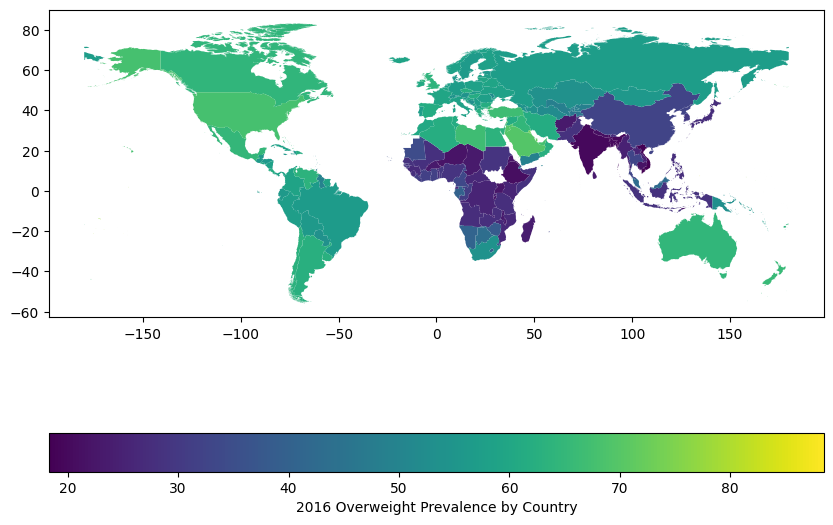

Exception in thread Thread-845 (<lambda>):
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-332 (<lambda>):
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-809 (<lambda>):
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-254 (<lambda>):
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framewor

In [123]:
# Non-interactive
p_2016 = m_2016.plot(
    column='Prevalence', 
    legend=True,
    legend_kwds={
        'label': "2016 Overweight Prevalence by Country",
        'orientation': "horizontal"
    },
    figsize=(10,10)
).get_figure()

p_2016.savefig('assets/2016.png')

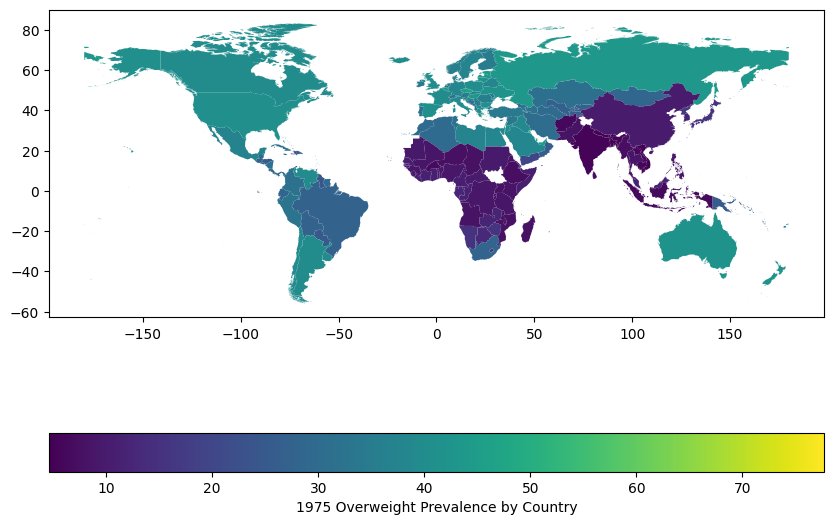

In [122]:
p_1975 = m_1975.plot(
    column='Prevalence', 
    legend=True,
    legend_kwds={
        'label': "1975 Overweight Prevalence by Country",
        'orientation': "horizontal"
    },
    figsize=(10,10)
).get_figure()

p_1975.savefig('assets/1975.png')

# Create Dash App

In [132]:
# Create app
app = JupyterDash(__name__)

colors = ['#a6cee3', '#1f78b4'] 

# dropdown menu options
country_options = [{'label': country, 'value': country} for country in df['Location'].unique()]
country_options = sorted(list(df['Location'].unique()))

# Define callbacks and functions
@app.callback(
    dash.dependencies.Output('female_vs_male', 'figure'),
    dash.dependencies.Input('plot1_dd', 'value')
)
def update_gender(country):   
    
    fig = px.line(
        df[(df['Gender'] != 'Both sexes') & (df['Location'] == country)],
        x='Period', 
        y='Prevalence', 
        #name=loc, 
        color='Gender',
        #hovertemplate=None,
        #showlegend=True
        
    )

    # Prettify
    fig.update_layout(
        template='simple_white',
        height=400
    )
    return fig

    
    # Create figure and traces
    fig = make_subplots(
        shared_xaxes=True, 
        shared_yaxes=True, 
        rows=1, 
        cols=2,
        vertical_spacing = 0,
        subplot_titles=("Gender = Female", "Gender = Male"),

    )

    for j, gender in enumerate(['Female', 'Male']):
        for i, loc in enumerate([country1, country2]):
            fig.add_trace(
                go.Scatter(
                    x=df[
                        (df['Gender'] == gender) 
                        & (df['Location'] == loc)
                    ]['Period'], 
                    y=df[
                        (df['Gender'] == gender) 
                        & (df['Location'] == loc)
                    ]['Prevalence'], 
                    name=loc, 
                    line=go.scatter.Line(color=colors[i]), 
                    hovertemplate=None,
                    showlegend=False if j==0 else True,
                ), 
                row=1, 
                col=j+1 
            )

    # Prettify
    fig.update_xaxes(showspikes=True, spikemode="across")
    fig.update_layout(
        hovermode="x",
        template='simple_white',
        height=400
    )

    return fig


@app.callback(
    dash.dependencies.Output('country_vs_country', 'figure'),
    dash.dependencies.Input('country1_dropdown', 'value'),
    dash.dependencies.Input('country2_dropdown', 'value')
)
def update_country_chart(country1, country2):   
    
    # Create figure and traces
    fig = make_subplots(
        shared_xaxes=True, 
        shared_yaxes=True, 
        rows=1, 
        cols=2,
        vertical_spacing = 0,
        subplot_titles=("Gender = Female", "Gender = Male"),

    )

    for j, gender in enumerate(['Female', 'Male']):
        for i, loc in enumerate([country1, country2]):
            fig.add_trace(
                go.Scatter(
                    x=df[
                        (df['Gender'] == gender) 
                        & (df['Location'] == loc)
                    ]['Period'], 
                    y=df[
                        (df['Gender'] == gender) 
                        & (df['Location'] == loc)
                    ]['Prevalence'], 
                    name=loc, 
                    line=go.scatter.Line(color=colors[i]), 
                    hovertemplate=None,
                    showlegend=False if j==0 else True,
                    
                ), 
                row=1, 
                col=j+1 
            )

    # Prettify
    fig.update_xaxes(showspikes=True, spikemode="across")
    fig.update_layout(
        hovermode="x",
        template='simple_white',
        height=400
    )

    return fig

    
def top1975_vs_2016():
    
    top_2016 = df[df['Period'] == 2016].sort_values('Prevalence', ascending=False)
    top_1975 = df[df['Period'] == 1975].sort_values('Prevalence', ascending=False)
    
    tops = [top_1975, top_2016]
    
    # Create figure and traces
    fig = make_subplots(
        shared_yaxes=True, 
        rows=3, 
        cols=2,
        vertical_spacing = 0.2,
        subplot_titles=("1975", "2016")
        #subplot_titles=("Gender = Female", "Gender = Male", "Gender = Both"),

    )

    for i, gender in enumerate(['Female', 'Male', "Both sexes"]):
        for j, temp_df in enumerate(tops):
            fig.add_trace(
                go.Bar(
                    x=temp_df[(temp_df['Gender'] == gender)]['Location'].head(15), 
                    y=temp_df[(temp_df['Gender'] == gender)]['Prevalence'].head(15), 
                    #name=gender, 
                    hovertemplate=None,
                    marker=dict(color = temp_df[(temp_df['Gender'] == gender)]['Prevalence'].head(15), colorscale='viridis'),
                    showlegend=False
                ), 
                row=i+1, 
                col=j+1 
            )

    # Prettify
    fig.update_xaxes(showspikes=True, spikemode="across", tickangle=45)
    fig.update_yaxes(title_text="Female", row=1, col=1)
    fig.update_yaxes(title_text="Male", row=2, col=1)
    fig.update_yaxes(title_text="Both sexes", row=3, col=1)
    fig.update_layout(
        template='simple_white',
    )

    return fig

def compare_differences():
    
    top_2016 = df[df['Period'] == 2016].sort_values('Prevalence', ascending=False)
    top_1975 = df[df['Period'] == 1975].sort_values('Prevalence', ascending=False)
    
    top_2016.columns = ['ParentLocation', 'Location', 'Period', 'Gender', 'Prevalence_16']
    top_1975.columns = ['ParentLocation', 'Location', 'Period', 'Gender', 'Prevalence_75']

    merged = top_2016[[
        'Location', 'Gender', 'Prevalence_16'
    ]].merge(top_1975[['Location', 'Gender', 'Prevalence_75']])

    merged['PrevalenceDiff'] = merged['Prevalence_16']-merged['Prevalence_75']

    #top_2016['TotalIncrease'] = top_2016['TotalIncrease']
    merged.sort_values('PrevalenceDiff', ascending=False, inplace=True)

    # Create figure and traces
    fig = make_subplots(
        shared_yaxes=True, 
        rows=3, 
        cols=2,
        vertical_spacing = 0.25,
        subplot_titles=("Higher Increase", "Lower Increase"),

    )

    for i, gender in enumerate(['Female', 'Male', "Both sexes"]):
        for j, b in enumerate([True, False]):
            if b:
                temp_df = merged[(merged['Gender'] == gender)]
            else:
                temp_df = merged[(merged['Gender'] == gender)].sort_values('PrevalenceDiff')
            fig.add_trace(
                go.Bar(
                    x=temp_df['Location'].head(15), 
                    y=temp_df['PrevalenceDiff'].head(15), 
                    #name=gender, 
                    hovertemplate=None,
                    marker=dict(color = merged[(merged['Gender'] == gender)]['PrevalenceDiff'].head(15), colorscale='viridis'),
                    showlegend=False
                ), 
                row=i+1, 
                col=j+1 
            )

    # Prettify
    fig.update_xaxes(showspikes=True, spikemode="across", tickangle=50)
    fig.update_yaxes(title_text="Female", row=1, col=1)
    fig.update_yaxes(title_text="Male", row=2, col=1)
    fig.update_yaxes(title_text="Both sexes", row=3, col=1)
    fig.update_layout(
        template='simple_white',
        #height=1000
    )
    return fig



# 1st row: Male vs Female by country, Continents, Country vs country
# 2nd row: 1975 vs 2016, maps stacked, Higher vs Fewer increase

male_vs_female = html.Div([
    dcc.Dropdown(
        id='plot1_dd',
        options=df['Location'].unique().tolist(),
        value='',
        placeholder='Select a country',
        style={'max-width': '200px', 'margin-left': '30px'}
    ),
    dcc.Graph(
        id='female_vs_male', 
        style={}
    )
],
    style={
        'grid-column-start' : 2,
        'grid-column-end' : 3,
        'grid-row-start': 'first-r',
        'grid-row-end': 'second-r',
        'padding': '2%'
        
    }
)

country_vs_country = html.Div([
    html.Div([
        dcc.Dropdown(
            id='country1_dropdown',
            options=df['Location'].unique().tolist(),
            value='',
            placeholder='Select a country',
            style={'width': '200px', 'display': 'inline-block', 'margin-right': '40px', 'margin-left': '30px'}
        ),
        dcc.Dropdown(
             id='country2_dropdown',
             options=df['Location'].unique().tolist(),
             value='',
             placeholder='Select a country',
             style={'width': '200px', 'display': 'inline-block'}
        )
    ],
        style={}
    ),
    dcc.Graph(
        id='country_vs_country', 
        #style={}
    )
], style={
    'grid-column-start' : 2, 
    'grid-column-start': 3,
    'grid-row-start': 'second-r',
    'grid-row-end': 'third-r',
    'padding': '2%'
})

year_tops = html.Div([
    dcc.Graph(
        id='year_tops', 
        figure=top1975_vs_2016(),
        style={'justify-self': 'stretch', 'height': '80vh'}
    )
], style={
    'grid-column-start' : 'first',
    'grid-column-end' : 'second',
    'grid-row-start': 'first-r',
    'grid-row-end': 'span 2',
    'padding': '2%'
})

year_differences = html.Div([
    dcc.Graph(
        id='year_differences', 
        figure=compare_differences(),
        style={'justify-self': 'stretch', 'height': '80vh'}
    )
], style={
    'grid-column-start' : 'third',
    'grid-column-end' : 'span 1',
    'grid-row-start': 'first-r',
    'grid-row-end': 'span 2',
    'padding': '2%'
})

continents = html.Div([
    dcc.Graph(
        id='continents', 
        figure=create_continents_chart(),
        style={}
    )
], style={
    'grid-column-start' : 2,
    'grid-column-end' : 3,
    'grid-row-start': 'third-r',
    'grid-row-end': 'span 1',
    'padding': '2%'
})

map_1975 = html.Div([
    html.H1('1975'),
    html.Img(src=dash.get_asset_url('1975.png'), 
             style={ 'max-width': '100%', 'justify-self': 'stretch'})
],
    style = {
        'grid-column-start': 2,
        'grid-column-end': 3,
        'grid-row-start': 'third-r',
        'grid-row-end': 'span 1',
        'text-align': 'center',
        'padding': '2%'
    }
)

map_2016 = html.Div([
    html.H1('2016'),
    html.Img(src=dash.get_asset_url('2016.png'), style={ 'max-width': '100%'})
],
    style = {
        'grid-column-start': 'third',
        'grid-column-end': 'span 1',
        'grid-row-start': 'third-r',
        'grid-row-end': 'span 1',
        'text-align': 'center',
        'padding': '2%'
        
    }
)



app.layout = html.Div([
    male_vs_female, continents, country_vs_country,
    year_tops, year_differences, map_1975, map_2016
],
    style={
    'width': '100vw',
    'display': 'inline-grid',
    'grid-template-columns': '[first] 33vw [second] 33vw [third] 33vw',
    'grid-template-rows': '[first-r] 40vh [second-r] 40vh [third-r] 20vh',
    #'grid-gap': '10px',
    #'align-items': 'right',
}
)


# Run app
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash app running on http://127.0.0.1:8050/
